In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
import scipy as scipy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#Import Boundary.py where the boundary geometric features are defined
#from Boundary import *

In [2]:
#function to compute Gauss-Legendre nodes and weights
# Compute the Gauss Legendre quadrature points and weights using
# the method given in Spectral Methods in MATLAB by L. N. Trefethen (2000).
#
# Following implementation in Matlab by A. D. Kim.

def GaussLegendre(N):
    #N: number of nodes 
    
    beta = np.zeros(N-1)
    
    for i in range(1, N):
        beta[i-1]  = 0.5 / np.sqrt( 1.0 - (1 / ( 2.0 * i )**2) );
        
    T = np.diag(beta, k=1) + np.diag(beta, k=-1) 
    x, v = np.linalg.eig(T)
    i = np.argsort(x)
    x = x[i]
    w = 2.0 * v[0,i]**2
    
    return x, w
    

In [3]:
#functions that compute properties of the surface - currently just a sphere 

def SphereRotation( s, t, theta0, phi0 ):
# This function computes the rotation from the (s,t) angles on the unit
# sphere to the (theta,phi) angles on the unit sphere. See Appendix A of
# Carvalho, Khatri, and Kim (2020) for the mathematical details.
#
# Following implementation in Matlab by A. D. Kim 

    #compute the auxilliary variables

    xi   = ( np.cos( theta0 ) * np.cos( phi0 ) * np.sin( s ) * np.cos( t ) 
            - np.sin( phi0 ) * np.sin( s ) * np.sin( t ) 
            + np.sin( theta0 ) * np.cos( phi0 ) * np.cos( s ) )

    eta  = ( np.cos( theta0 ) * np.sin( phi0 ) * np.sin( s ) * np.cos( t ) 
            + np.cos( phi0 ) * np.sin( s ) * np.sin( t ) 
            + np.sin( theta0 ) * np.sin( phi0 ) * np.cos( s ) )

    zeta = - np.sin( theta0 ) * np.sin( s ) * np.cos( t ) + np.cos( theta0 ) * np.cos( s )

    #compute the rotated angles

    theta = np.arctan2( np.sqrt( xi**2 + eta**2 ), zeta )
    phi   = np.arctan2( eta, xi );

    return theta, phi

def ComputeSurface(s,t):
    
    a = 1.
    b = 1.5
    c = 2.
    
    #surface vector
    x = a*np.sin( s ) * np.cos( t ) # this is an ellipsoid now
    y = b*np.sin( s ) * np.sin( t )
    z = c*np.cos( s )
    
    #outward point normal vector
    nx = x/a**2 
    ny = y/b**2 
    nz = z/c**2 

    mag = np.sqrt(nx**2+ny**2+nz**2)
    
    nx = nx/mag
    ny = ny/mag
    nz = nz/mag
    
    #Jacobian of the mapping of the surface to a sphere 
    #J = 0*s + 1.0 
    bcx = b*c*x/a
    acy = a*c*y/b
    abz = a*b*z/c
    
    J = np.sqrt(bcx**2+acy**2+abz**2)
    
    return x, y, z, nx, ny, nz, J

    
def ComputeSurfaceRotation(s, t, theta0, phi0 ):
        
    theta, phi = SphereRotation( s, t, theta0, phi0 );

    x, y, z, nx, ny, nz, J = ComputeSurface(theta,phi)
    
    return theta, phi, x, y, z, nx, ny, nz, J

In [4]:
#Gauss - Legendre 
M = 2
z, w = GaussLegendre(M)
s = np.arccos(z)

#Trapezoid Rule 
N = 2*M 
LN = 2*np.pi
dt = LN/N
t = np.linspace(-np.pi, -np.pi+LN, N, endpoint=False) 

sM, tM = np.meshgrid(s, t, sparse=False, indexing='ij')
sV = sM.flatten()
tV = tM.flatten()

wV = np.full(M*N, 0.0)
counter = 0 
for i, wi in enumerate(w):
    for j, tj in enumerate(t):
        wV[counter] = w[i]
        counter = counter+1 


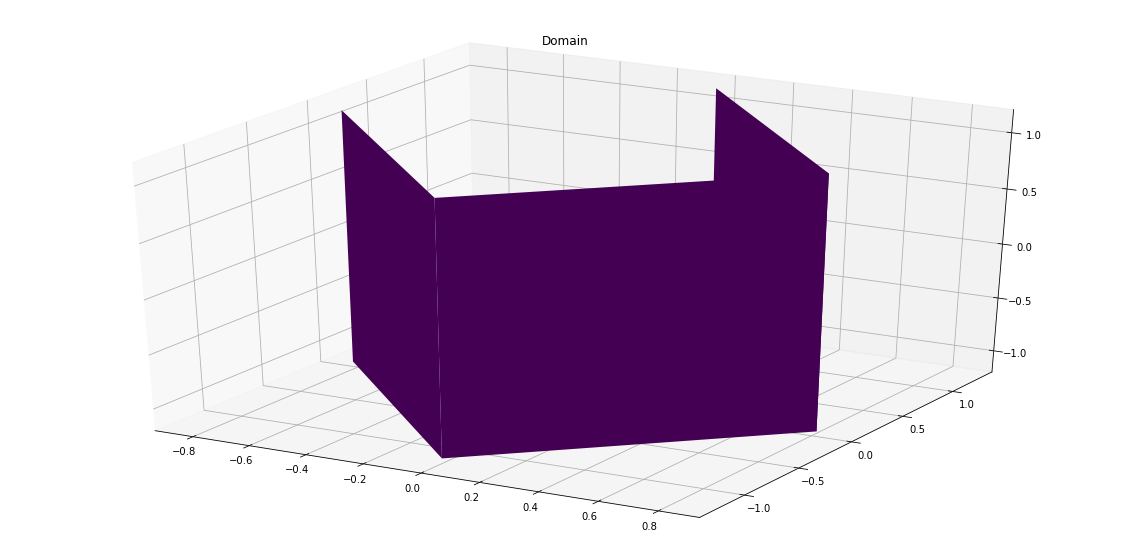

In [5]:
#only used to plot surface 
y00, y10, y20, n00, n10, n20, J0 = ComputeSurface(sV, tV)

y0M = np.reshape(y00,(M,N))
y1M = np.reshape(y10,(M,N))
y2M = np.reshape(y20,(M,N))

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.set_title('Domain')
#ax.contour3D(y0M, y1M, y2M, 50, cmap='binary')
ax.plot_surface(y0M, y1M, y2M, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

In [6]:
#functions for computing the kernel 

#evaluation of kernel given x and y, normal at y, Jacobian of mapping at y 
def evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2):

    rdiff = [x0 - y0, x1 - y1, x2 - y2]
    r_distance = np.sqrt(rdiff[0]**2 + rdiff[1]**2 + rdiff[2]**2)
    
    evalK = (Jy * ( ny0*rdiff[0] + ny1*rdiff[1] + ny2*rdiff[2] ) / ( r_distance**3 * 4 * np.pi ) )
    
    return evalK

#kernel evaluation if both points lie on the surface 
def K(s , t , theta0 , phi0):
    
    theta, phi, y0, y1, y2, ny0, ny1, ny2, Jy = ComputeSurfaceRotation(s, t, theta0, phi0 ) 
    x0, x1, x2, nx0, nx1, nx2, Jx = ComputeSurface(theta0, phi0)

    evalK = evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2)
    
    return theta, phi, evalK

#kernel evaluation if one point does not lie on the surface 
#Note theta0, phi0 needs to correspond to (x0, x1, x2)
def Koff(s, t, theta0, phi0, x0, x1, x2):

    theta, phi, y0, y1, y2, ny0, ny1, ny2, Jy = ComputeSurfaceRotation(s, t, theta0, phi0 ) 
    
    evalK = evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2)
    
    return theta, phi, evalK    
    
    
def ff(x0,x1,x2):

    return np.exp(x0)*np.cos(x1) + np.exp(x2)*np.sin(x0)

def RHSf(theta0 , phi0):
    
    x0, x1, x2, nx0, nx1, nx2, Jx = ComputeSurface( theta0, phi0)
    
    evalf = ff(x0,x1,x2)
    
    return evalf 
    
    #Other possible solutions:
    
    #return -1 
    
    #x00 = 5
    #y00 = 4
    #z00 = 3
    #ulen = np.sqrt( ( x0 - x00 )**2 + ( x1 - y00 )**2 + ( x2 - z00 )**2 )    
    #return 1/ulen


In [7]:
#Compute spherical harmonics matrix of order M 

Smk = np.zeros((M**2,N*M),dtype=np.complex_) #np.full((M**2,N*M), np.nan)

for j in range(0, N*M):
    
    counter = 0 
    
    for mm in range (0, M):
        for k in range (0, (2*mm) + 1):
        
            kindex = k - mm 
            Smk[counter,j] = scipy.special.sph_harm(kindex, mm, tV[j], sV[j] ) 
            
            counter = counter + 1
            


In [8]:
#Solving the BIE
#Notes:
#Using (M-1)st order for the spherical harmonic representation of the density - therefore we have M^2 spherical harmonics 

innerK = np.zeros((M**2,N*M),dtype=np.complex_)
kernel = np.zeros((M**2,M**2),dtype=np.complex_)
g = np.zeros(M**2,dtype=np.complex_)
mu = np.zeros(N*M,dtype=np.complex_)
mureal = np.zeros(N*M)

counter = -1

#First Inner product 

#looping over spherical harmonics (SK in my notes: mu kappa)
for mm in range (0, M):
    for kk in range (0, (2*mm) + 1):
        
        kkindex = kk - mm
        
        #counts the spherical harmonics functions from 0 to M^2-1 
        counter = counter + 1 
    
        #looping over all theta0 and phi0 values 
        for k in range (0,N*M):
            
            theta0 = sV[k]
            phi0 = tV[k]
            
            Smk2 = scipy.special.sph_harm( kkindex, mm, phi0, theta0 )  
        
            #loop to be able to sum the quadrature 
            for j in range (0,N*M):
        
                theta, phi, tempK = K( sV[j], tV[j], theta0, phi0 )
            
                Smk1 = scipy.special.sph_harm( kkindex, mm, phi, theta )  
                    
                innerK[counter,k] = innerK[counter,k] + np.pi*wV[j]*tempK*(Smk1-Smk2)/M
            
            innerK[counter,k] = innerK[counter,k] - Smk2/2
        
#Second Inner Product 

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0,M**2):
    
    #loop over all spherical harmonics (SK in my notes: mu kappa)
    for j in range(0, M**2):
        
        #loop to be able to sum the quadrature 
        for k in range(0,N*M): 
             
            kernel[i,j] = kernel[i,j] + np.pi*innerK[j,k]*wV[k]*Smk[i,k]/M

#RHS     

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0, M**2):
    
    #loop to be able to sum the quadrature 
    for k in range(0,N*M):
    
        g[i] = g[i] + np.pi*RHSf(sV[k],tV[k])*wV[k]*Smk[i,k]/M

A =  - 0.5 * np.identity(M**2) + kernel  
alpha = np.linalg.solve(A, g)

#Computing the density 
#for i in range(0, N*M):
#    
#    for j in range(0,M**2):
#
#            mu[i] = mu[i] + alpha[j]*Smk[j,i]
#            
#mureal = np.real(mu) 


In [9]:
Nr = 8
#ar = np.linspace(1., 0.5, Nr)
#br = np.linspace(1.5,1.,Nr)
#cr = np.linspace(2.,1.5,Nr)
r = np.linspace(1.,0.5,Nr)

yvalues = np.linspace(0,7,32)  # the maximum value (2nd element input) can be up to (N*M) - 1 
yvalues = yvalues.astype(int)
Ny = yvalues.size

x0 = np.full((Nr,Ny), np.nan)
x1 = np.full((Nr,Ny), np.nan)
x2 = np.full((Nr,Ny), np.nan)
u = np.zeros((Nr,Ny),dtype=np.complex_)
erroru = np.zeros((Nr,Ny),dtype=np.complex_)
exactu = np.full((Nr,Ny), np.nan)
ureal =np.full((Nr,Ny), np.nan)
errorureal =np.full((Nr,Ny), np.nan)

#Looping over x values 
for i in range(len(r)): 
    for j in range(len(yvalues)):   
        theta0 = sV[yvalues[j]]
        phi0 = tV[yvalues[j]]
        y0, y1, y2, n0, n1, n2, J = ComputeSurface(theta0, phi0)
        
        #Compute x value at where the solution will be evaluated
        x0[i,j] = y0 - n0*r[i]#n0*ar[i]
        x1[i,j] = y1 - n1*r[i]#n1*br[i]
        x2[i,j] = y2 - n2*r[i]#n2*cr[i]
        
        #computes mu for theta0/phi0 
        mu2 = 0 
        for mm in range (0,M**2):
            mu2 = mu2 + alpha[mm]*Smk[mm,yvalues[j]]
            
        #loop to be able to sum the quadrature 
        for k in range (0,N*M):
        
            theta, phi, tempK = Koff( sV[k], tV[k], theta0, phi0, x0[i,j], x1[i,j], x2[i,j] )
            
            #computes mu for rotated theta/phi
            mu1 = 0 
            counter = 0 
            for mm in range (0, M):
                for kk in range (0, (2*mm) + 1):
                    kindex = kk - mm 
                    mu1 = mu1 + alpha[counter]*scipy.special.sph_harm(kindex, mm, phi, theta )
                    counter = counter + 1   
            
            u[i,j] = u[i,j] + np.pi*tempK*wV[k]*(mu1-mu2)/M
        
        u[i,j] = u[i,j] - mu2 
        exactu[i,j] = ff(x0[i,j],x1[i,j],x2[i,j])
        erroru[i,j] = exactu[i,j]-u[i,j]    
       
        print("x: (%5.3f, %5.3f, %5.3f), \t u:%f \t erroru:%5.12f" % 
              (x0[i,j], x1[i,j], x2[i,j],  np.real(u[i,j]), abs(np.real(erroru[i,j])) ) )
             
        
ureal = np.real(u)
errorureal = np.abs(np.real(erroru))

        

x: (0.126, -0.000, -0.821), 	 u:2.862697 	 erroru:1.672652368708
x: (0.126, -0.000, -0.821), 	 u:2.862697 	 erroru:1.672652368708
x: (0.126, -0.000, -0.821), 	 u:2.862697 	 erroru:1.672652368708
x: (0.126, -0.000, -0.821), 	 u:2.862697 	 erroru:1.672652368708
x: (0.126, -0.000, -0.821), 	 u:2.862697 	 erroru:1.672652368708
x: (-0.000, -0.341, -0.686), 	 u:0.845727 	 erroru:0.096595642119
x: (-0.000, -0.341, -0.686), 	 u:0.845727 	 erroru:0.096595642119
x: (-0.000, -0.341, -0.686), 	 u:0.845727 	 erroru:0.096595642119
x: (-0.000, -0.341, -0.686), 	 u:0.845727 	 erroru:0.096595642119
x: (-0.126, 0.000, -0.821), 	 u:-1.171243 	 erroru:1.997174131755
x: (-0.126, 0.000, -0.821), 	 u:-1.171243 	 erroru:1.997174131755
x: (-0.126, 0.000, -0.821), 	 u:-1.171243 	 erroru:1.997174131755
x: (-0.126, 0.000, -0.821), 	 u:-1.171243 	 erroru:1.997174131755
x: (-0.126, 0.000, -0.821), 	 u:-1.171243 	 erroru:1.997174131755
x: (-0.000, 0.341, -0.686), 	 u:0.845727 	 erroru:0.096595642119
x: (-0.000, 0.34

x: (-0.000, 0.594, -0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, 0.594, -0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, 0.594, -0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, 0.594, -0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.143, -0.000, 0.917), 	 u:0.898366 	 erroru:0.388212340520
x: (-0.143, -0.000, 0.917), 	 u:0.898366 	 erroru:0.388212340520
x: (-0.143, -0.000, 0.917), 	 u:0.898366 	 erroru:0.388212340520
x: (-0.143, -0.000, 0.917), 	 u:0.898366 	 erroru:0.388212340520
x: (-0.143, -0.000, 0.917), 	 u:0.898366 	 erroru:0.388212340520
x: (-0.000, -0.594, 0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, -0.594, 0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, -0.594, 0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (-0.000, -0.594, 0.820), 	 u:0.845727 	 erroru:0.016854929539
x: (0.143, 0.000, 0.917), 	 u:0.793089 	 erroru:0.717259579592
x: (0.143, 0.000, 0.917), 	 u:0.793089 	 erroru:0.717259579592
x: (0.143, 0.000, 0.917), 	 u

In [10]:
print(t)

[-3.14159265 -1.57079633  0.          1.57079633]


In [11]:
# find u and error in xy plane

a = 1.
b = 1.5
c = 2.

plotn = 10
xyplane_x_values = np.linspace(-a + 0.7, a - 0.7, plotn)
xyplane_y_values = np.linspace(-b + 1.2, b - 1.2, plotn)

u = np.zeros((plotn,plotn),dtype=np.complex_)
erroru = np.zeros((plotn,plotn),dtype=np.complex_)
exactu = np.full((plotn,plotn), np.nan)
ureal = np.full((plotn,plotn), np.nan)
errorureal = np.full((plotn,plotn), np.nan)

for i in range(0, plotn):
    for j in range(0, plotn):
        
        theta0 = sV[yvalues[j]]
        phi0 = tV[yvalues[j]]
        y0, y1, y2, n0, n1, n2, J = ComputeSurface(theta0, phi0)     
        
        #computes mu for theta0/phi0 
        mu2 = 0 
        for mm in range (0,M**2):
            mu2 = mu2 + alpha[mm]*Smk[mm,yvalues[j]]
        
        #loop to be able to sum the quadrature 
        for k in range (0,N*M):
        
            theta, phi, tempK = Koff(sV[k], tV[k], theta0, phi0, xyplane_x_values[i], xyplane_y_values[j], 0.0 )
            
            #computes mu for rotated theta/phi
            mu1 = 0 
            counter = 0 
            for mm in range (0, M):
                for kk in range (0, (2*mm) + 1):
                    kindex = kk - mm 
                    mu1 = mu1 + alpha[counter]*scipy.special.sph_harm(kindex, mm, phi, theta )
                    counter = counter + 1   
            
            u[i,j] = u[i,j] + np.pi*tempK*wV[k]*(mu1-mu2)/M
        
        u[i,j] = u[i,j] - mu2 
        exactu[i,j] = ff(xyplane_x_values[i], xyplane_y_values[j], 0.0)
        erroru[i,j] = exactu[i,j]-u[i,j]    
       
        print("x: (%5.3f, %5.3f, %5.3f), \t u:%f \t erroru:%5.12f" % 
              (xyplane_x_values[i], xyplane_y_values[j], 0.0, np.real(u[i,j]), abs(np.real(erroru[i,j])) ) )

             
        
ureal = np.real(u)
errorureal = np.abs(np.real(erroru))


x: (-0.300, -0.300, 0.000), 	 u:0.174293 	 erroru:0.237917508993
x: (-0.300, -0.233, 0.000), 	 u:0.170732 	 erroru:0.254491045996
x: (-0.300, -0.167, 0.000), 	 u:0.167860 	 erroru:0.267172330311
x: (-0.300, -0.100, 0.000), 	 u:0.165860 	 erroru:0.275737214440
x: (-0.300, -0.033, 0.000), 	 u:0.164835 	 erroru:0.280051784671
x: (-0.300, 0.033, 0.000), 	 u:0.262968 	 erroru:0.181918663542
x: (-0.300, 0.100, 0.000), 	 u:0.252148 	 erroru:0.189448744118
x: (-0.300, 0.167, 0.000), 	 u:0.231607 	 erroru:0.203425933767
x: (-0.300, 0.233, 0.000), 	 u:0.203550 	 erroru:0.221672178937
x: (-0.300, 0.300, 0.000), 	 u:0.074728 	 erroru:0.337482557041
x: (-0.233, -0.300, 0.000), 	 u:0.359724 	 erroru:0.165575338350
x: (-0.233, -0.233, 0.000), 	 u:0.359683 	 erroru:0.179525006859
x: (-0.233, -0.167, 0.000), 	 u:0.359910 	 erroru:0.189784715021
x: (-0.233, -0.100, 0.000), 	 u:0.360217 	 erroru:0.196494678633
x: (-0.233, -0.033, 0.000), 	 u:0.360424 	 erroru:0.199804285821
x: (-0.233, 0.033, 0.000), 	 u

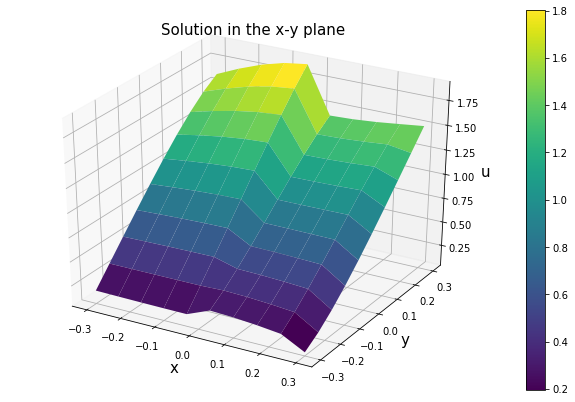

In [12]:
X, Y = np.meshgrid(xyplane_x_values, xyplane_y_values)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Solution in the x-y plane',fontsize=15)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_zlabel('u', fontsize=15)
surf = ax.plot_surface(X, Y, ureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)

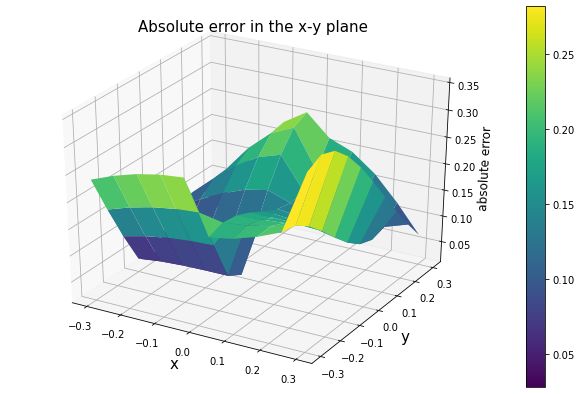

In [13]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute error in the x-y plane',fontsize=15)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_zlabel('absolute error', fontsize=12)
surf = ax.plot_surface(X, Y, errorureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)

In [14]:
# find error and u in xz plane
# reduce range to get smaller error over smaller region

a = 1.
b = 1.5
c = 2.

plotn = 10
xzplane_x_values = np.linspace(-a + 0.7, a - 0.7, plotn)
xzplane_z_values = np.linspace(-c + 1.7, c - 1.7, plotn)

u = np.zeros((plotn,plotn),dtype=np.complex_)
erroru = np.zeros((plotn,plotn),dtype=np.complex_)
exactu = np.full((plotn,plotn), np.nan)
ureal = np.full((plotn,plotn), np.nan)
errorureal = np.full((plotn,plotn), np.nan)

for i in range(0, plotn):
    for j in range(0, plotn):
        
        theta0 = sV[yvalues[j]]
        phi0 = tV[yvalues[j]]
        y0, y1, y2, n0, n1, n2, J = ComputeSurface(theta0, phi0)     
        
        #computes mu for theta0/phi0 
        mu2 = 0 
        for mm in range (0,M**2):
            mu2 = mu2 + alpha[mm]*Smk[mm,yvalues[j]]
        
        #loop to be able to sum the quadrature 
        for k in range (0,N*M):
        
            theta, phi, tempK = Koff(sV[k], tV[k], theta0, phi0, xzplane_x_values[i], 0.0, xzplane_z_values[j] )
            
            #computes mu for rotated theta/phi
            mu1 = 0 
            counter = 0 
            for mm in range (0, M):
                for kk in range (0, (2*mm) + 1):
                    kindex = kk - mm 
                    mu1 = mu1 + alpha[counter]*scipy.special.sph_harm(kindex, mm, phi, theta )
                    counter = counter + 1   
            
            u[i,j] = u[i,j] + np.pi*tempK*wV[k]*(mu1-mu2)/M
        
        u[i,j] = u[i,j] - mu2 
        exactu[i,j] = ff(xzplane_x_values[i], 0.0, xzplane_z_values[j])
        erroru[i,j] = exactu[i,j]-u[i,j]    
       
        print("x: (%5.3f, %5.3f, %5.3f), \t u:%f \t erroru:%5.12f" % 
              (xzplane_x_values[i], 0.0, xzplane_z_values[j], np.real(u[i,j]), abs(np.real(erroru[i,j])) ) )

             
        
ureal = np.real(u)
errorureal = np.abs(np.real(erroru))

x: (-0.300, 0.000, -0.300), 	 u:0.474904 	 erroru:0.046987558562
x: (-0.300, 0.000, -0.233), 	 u:0.421294 	 erroru:0.085504802833
x: (-0.300, 0.000, -0.167), 	 u:0.357566 	 erroru:0.133099868197
x: (-0.300, 0.000, -0.100), 	 u:0.285472 	 erroru:0.187948820293
x: (-0.300, 0.000, -0.033), 	 u:0.206456 	 erroru:0.248529999045
x: (-0.300, 0.000, 0.033), 	 u:0.262855 	 erroru:0.172426507505
x: (-0.300, 0.000, 0.100), 	 u:0.251144 	 erroru:0.163074040029
x: (-0.300, 0.000, 0.167), 	 u:0.228882 	 erroru:0.162819980203
x: (-0.300, 0.000, 0.233), 	 u:0.198382 	 erroru:0.169252879780
x: (-0.300, 0.000, 0.300), 	 u:0.942544 	 erroru:0.600636803428
x: (-0.233, 0.000, -0.300), 	 u:0.719155 	 erroru:0.098558626813
x: (-0.233, 0.000, -0.233), 	 u:0.653512 	 erroru:0.044724238577
x: (-0.233, 0.000, -0.167), 	 u:0.577815 	 erroru:0.018349099319
x: (-0.233, 0.000, -0.100), 	 u:0.494637 	 erroru:0.088034810924
x: (-0.233, 0.000, -0.033), 	 u:0.406144 	 erroru:0.162104201351
x: (-0.233, 0.000, 0.033), 	 u

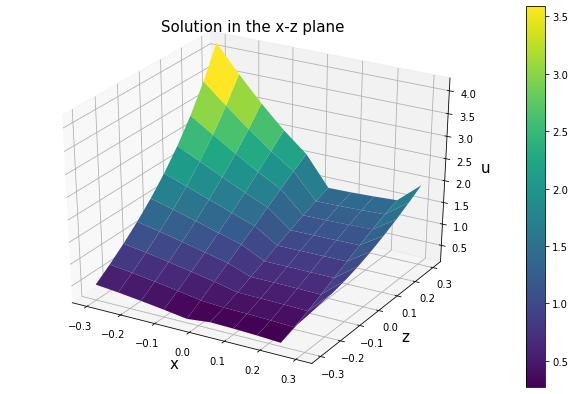

In [15]:
X, Z = np.meshgrid(xzplane_x_values, xzplane_z_values)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Solution in the x-z plane',fontsize=15)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_zlabel('u', fontsize=15)
surf = ax.plot_surface(X, Z, ureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)

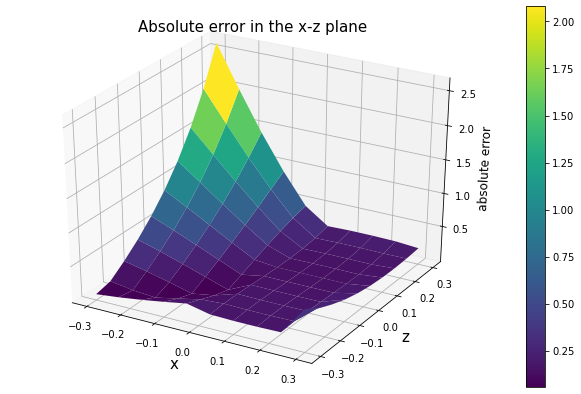

In [16]:
X, Z = np.meshgrid(xzplane_x_values, xzplane_z_values)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute error in the x-z plane',fontsize=15)
ax.set_xlabel('x',fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_zlabel('absolute error', fontsize=12)
surf = ax.plot_surface(X, Z, errorureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)

In [17]:
# find error and u in yz plane

a = 1.
b = 1.5
c = 2.

plotn = 10
yzplane_y_values = np.linspace(-b + 1.2, b - 1.2, plotn)
yzplane_z_values = np.linspace(-c + 1.7, c - 1.7, plotn)

u = np.zeros((plotn,plotn),dtype=np.complex_)
erroru = np.zeros((plotn,plotn),dtype=np.complex_)
exactu = np.full((plotn,plotn), np.nan)
ureal = np.full((plotn,plotn), np.nan)
errorureal = np.full((plotn,plotn), np.nan)

for i in range(0, plotn):
    for j in range(0, plotn):
        
        theta0 = sV[yvalues[j]]
        phi0 = tV[yvalues[j]]
        y0, y1, y2, n0, n1, n2, J = ComputeSurface(theta0, phi0)     
        
        #computes mu for theta0/phi0 
        mu2 = 0 
        for mm in range (0,M**2):
            mu2 = mu2 + alpha[mm]*Smk[mm,yvalues[j]]
        
        #loop to be able to sum the quadrature 
        for k in range (0,N*M):
        
            theta, phi, tempK = Koff(sV[k], tV[k], theta0, phi0, 0.0, yzplane_y_values[i], yzplane_z_values[j] )
            
            #computes mu for rotated theta/phi
            mu1 = 0 
            counter = 0 
            for mm in range (0, M):
                for kk in range (0, (2*mm) + 1):
                    kindex = kk - mm 
                    mu1 = mu1 + alpha[counter]*scipy.special.sph_harm(kindex, mm, phi, theta )
                    counter = counter + 1   
            
            u[i,j] = u[i,j] + np.pi*tempK*wV[k]*(mu1-mu2)/M
        
        u[i,j] = u[i,j] - mu2 
        exactu[i,j] = ff(0.0, yzplane_y_values[i], yzplane_z_values[j])
        erroru[i,j] = exactu[i,j]-u[i,j]    
       
        print("x: (%5.3f, %5.3f, %5.3f), \t u:%f \t erroru:%5.12f" % 
              (0.0, yzplane_y_values[i], yzplane_z_values[j], np.real(u[i,j]), abs(np.real(erroru[i,j])) ) )

             
        
ureal = np.real(u)
errorureal = np.abs(np.real(erroru))

x: (0.000, -0.300, -0.300), 	 u:1.503357 	 erroru:0.548020870580
x: (0.000, -0.300, -0.233), 	 u:1.392889 	 erroru:0.437552647580
x: (0.000, -0.300, -0.167), 	 u:1.276225 	 erroru:0.320888583752
x: (0.000, -0.300, -0.100), 	 u:1.159698 	 erroru:0.204361192341
x: (0.000, -0.300, -0.033), 	 u:1.048156 	 erroru:0.092819530161
x: (0.000, -0.300, 0.033), 	 u:0.845727 	 erroru:0.109609339613
x: (0.000, -0.300, 0.100), 	 u:0.845727 	 erroru:0.109609339613
x: (0.000, -0.300, 0.167), 	 u:0.845727 	 erroru:0.109609339613
x: (0.000, -0.300, 0.233), 	 u:0.845727 	 erroru:0.109609339613
x: (0.000, -0.300, 0.300), 	 u:1.067273 	 erroru:0.111936776734
x: (0.000, -0.233, -0.300), 	 u:1.608482 	 erroru:0.635580918180
x: (0.000, -0.233, -0.233), 	 u:1.481257 	 erroru:0.508356295018
x: (0.000, -0.233, -0.167), 	 u:1.346835 	 erroru:0.373933536394
x: (0.000, -0.233, -0.100), 	 u:1.211843 	 erroru:0.238942042698
x: (0.000, -0.233, -0.033), 	 u:1.081344 	 erroru:0.108443012595
x: (0.000, -0.233, 0.033), 	 u

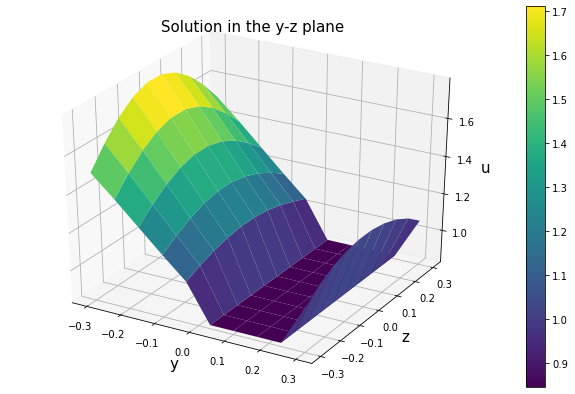

In [18]:
Y, Z = np.meshgrid(yzplane_y_values, yzplane_z_values)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Solution in the y-z plane',fontsize=15)
ax.set_xlabel('y',fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_zlabel('u', fontsize=15)
surf = ax.plot_surface(Y, Z, ureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)

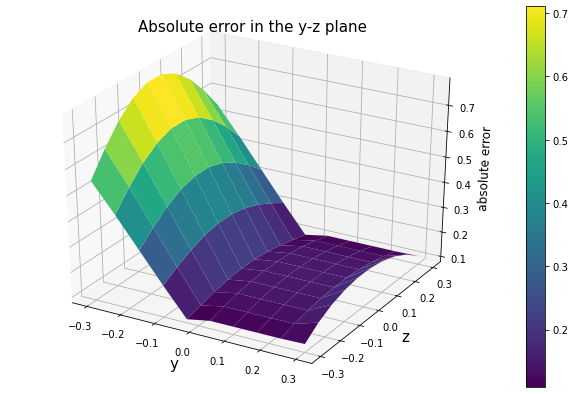

In [19]:
Y, Z = np.meshgrid(yzplane_y_values, yzplane_z_values)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute error in the y-z plane',fontsize=15)
ax.set_xlabel('y',fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_zlabel('absolute error', fontsize=12)
surf = ax.plot_surface(Y, Z, errorureal, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(surf, orientation='vertical', fraction=0.07)